# Pipeline Design of AI Agent in Urban Public Space Design Assistance
# 面向城市公共空间营造辅助的大模型智能体研究
本项目为建筑领域中人工智能体的应用尝试，主要针对前期的设计推断和流程进行优化和调整。本项目主要针对城市公共空间设计过程中可能遇到的问题提出，项目分为三个不同的模块，分别为用户研究模块，专家部署模块和设计咨询模块，前两者均为建立不同的Agent辅助第三个模块使用。在测试中，由于需要用到生图和识图功能，所有的智能体工具大模型均基于OpenAI的GPT4相关工具（GPT4V,Dalle生图工具）使用，其余API支持暂时没有测试。

## Requirement
1. autogenstudio  0.0.47
2. pyautogen 0.2.22 https://github.com/microsoft/autogen
3. python 3.11.8

## Usage 
OAI_CONFIG_LIST存放了我们大模型相关的API key。首先我们需要先修改OAI_CONFIG_LIST中的内容，将其模型名称，apikey和请求链接均修改为对应相关链接
如：

        "model": "gpt-4",
        "api_key": "sk-....",
        "base_url": "...."

然后我们开始运行以下代码。此部分代码主要是进行Agent前期配置。

In [131]:
import os
import json
import pdb
import random
import re
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import PIL
import requests
from diskcache import Cache
from openai import OpenAI
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, gpt4v_formatter, get_pil_image
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

file_path = 'OAI_CONFIG_LIST'

with open(file_path, 'r', encoding='utf-8') as file:
    config_data = json.load(file)

os.environ["OPENAI_API_KEY"] = config_data[0]['api_key']
os.environ["OPENAI_BASE_URL"] = config_data[0]['base_url']

gpt_config = [
    {
        "model": "gpt-4",
        "api_key": os.environ["OPENAI_API_KEY"],
        #'api_version': '2024-02-15-preview',
    }
]

gpt4v_config = [
    {
        "model": "gpt-4-vision-preview",
        "api_key": os.environ["OPENAI_API_KEY"],
        #'api_version': '2024-02-15-preview',
    }
]

dalle_config = [
    {
        'model': 'dalle',
        'api_key': os.environ["OPENAI_API_KEY"],
        #'api_version': '2024-02-15-preview',
    }
]

termination_notice = (
    '\n\n注意在对话中，请不要表示任何的感恩情感，只说关键的必要的部分，不需要询问对方你还有其他需求或其他任务'
    '如果一旦发现对话中，自己出现"表示感谢"，或者"不用客气"，"祝一切安好","如果您有其他需求，请随时告诉我"。等没有实际知识性意义的内容，请立刻在内容后加入TERMINATE来终止这场对话，并且以当前对话作为你的last message。'
)


In [132]:
task_description = """项目名称：深圳南山区城中村活动中心更新项目
    地点：深圳市南山区城中村
    项目类型：城市更新
    占地面积：约1000平方米
    项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求。
    设计目标
    可持续发展：应用绿色建筑材料和技术，减少环境影响，确保项目的可持续性。
    灵活多用途空间：设计灵活的空间布局，以适应会议、展览、表演、休闲等多种用途。
    社区参与和归属感：鼓励社区居民参与设计和管理过程，增强社区归属感。
    文化融合：反映和融合城中村的历史文化元素，促进不同背景社区成员之间的文化交流。
    设计范围
    建筑设计：包括但不限于主体结构改造、外观设计、室内设计等。
    景观设计：包括户外休闲空间、绿化、以及适应各种社区活动的开放空间设计。
    室内布局：创造多功能空间，如图书馆、小剧场、会议室、工作坊、儿童游戏区等。
    环境友好：设计应考虑能源效率，使用可持续材料，以及雨水收集和利用系统。
    设计要求
    创新：鼓励采用创新的设计理念和技术，以提供独特的视觉和使用体验。
    灵活性：空间布局应灵活，能够适应不同活动和功能的需要。
    安全性：确保建筑物和周围环境的安全性，符合当地建筑规范和安全标准。
    文化敏感性：设计应敏感地反映和尊重当地社区的文化和历史。
    提交要求
    设计方案：包括概念设计方案、平面图、立面图、剖面图等。
    可行性报告：分析项目的经济、环境和社会可行性。
    材料和技术说明：详细说明选用的建筑材料、构造方法和环境技术。
    预算估算：提供项目的初步成本估算。
    时间表：项目的预计设计和施工时间表。
    评审和批准
    设计方案将由一个专家评审小组进行评审，评审标准包括创意、功能性、可持续性、以及社区参与度。通过评审的设计方案将进入下一阶段的详细设计和实施。
"""

### RAG相关配置
这部分代码主要是实现向量数据库于大语言模型结合的应用，进行对智能体Agent的初始化配置，提高其对任务书的理解能力。向量数据库主要基于Qdrant平台提供的服务

In [45]:
from sentence_transformers import SentenceTransformer
import numpy as np
import json
import pandas as pd
from tqdm.notebook import tqdm

# 需要是multi line的数据结构
datasetname = "modified.json"

model = SentenceTransformer(
    "all-MiniLM-L6-v2", device="cuda"
)  # or device="cpu" if you don't have a GPU
df = pd.read_json(datasetname, lines=True)

# Turn name and decription into vector, if possible, turn all the decription into question, that will be better
vectors = model.encode(
    [str(row.name) + ". " + str(row.content) for row in df.itertuples()],
    show_progress_bar=True,
)

np.save("architecture_vectors.npy", vectors, allow_pickle=False)
vectors.shape

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

In [47]:
# 部署Qdrant相关的设置

from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

qdrant_client = QdrantClient(
    url="https://d6ebf209-41d2-4b54-a116-067a12dab274.us-east4-0.gcp.cloud.qdrant.io:6333", 
    api_key="mvoTfM2rbPRTP2miB0ZQh2TTO2NWF1MGemXe-z81zi2ulSiuO2styw",
)

qdrant_client.recreate_collection(
    collection_name="architectures_des",
    vectors_config=VectorParams(size = model.get_sentence_embedding_dimension(), distance=Distance.COSINE),
)

fd = open(datasetname) # 原始文件
payload = map(json.loads, fd)
vectors = np.load("architecture_vectors.npy")

qdrant_client.upload_collection(
    collection_name="architectures_des",
    vectors=vectors,
    payload=payload,
    ids=None,  # Vector ids will be assigned automatically
    batch_size=256,  # How many vectors will be uploaded in a single request?
)

True

In [68]:
model = SentenceTransformer(
    "all-MiniLM-L6-v2", device="cuda"
)  # or device="cpu" if you don't have a GPU
li = model.encode(["你好shaea-eianiosen", "sdaiubdiuabi"])
li.shape

(2, 384)

In [50]:
# 向量数据库测试代码
hits = qdrant_client.search(
    collection_name="architectures_des",
    query_vector=model.encode("""
                设计目标
                可持续发展：应用绿色建筑材料和技术，减少环境影响，确保项目的可持续性。
                灵活多用途空间：设计灵活的空间布局，以适应会议、展览、表演、休闲等多种用途。
                社区参与和归属感：鼓励社区居民参与设计和管理过程，增强社区归属感。
                文化融合：反映和融合城中村的历史文化元素，促进不同背景社区成员之间的文化交流。
                设计范围
                建筑设计：包括但不限于主体结构改造、外观设计、室内设计等。
                景观设计：包括户外休闲空间、绿化、以及适应各种社区活动的开放空间设计。
                室内布局：创造多功能空间，如图书馆、小剧场、会议室、工作坊、儿童游戏区等。
                环境友好：设计应考虑能源效率，使用可持续材料，以及雨水收集和利用系统。
                设计要求
                创新：鼓励采用创新的设计理念和技术，以提供独特的视觉和使用体验。
                灵活性：空间布局应灵活，能够适应不同活动和功能的需要。
                安全性：确保建筑物和周围环境的安全性，符合当地建筑规范和安全标准。
                文化敏感性：设计应敏感地反映和尊重当地社区的文化和历史。                              
                              """).tolist(),
    limit=5,
)
for hit in hits:
    print(hit.payload, "score:", hit.score)

{'content': '6北镰仓之屋，房屋的社会性/对当地社区开放。建筑位于北镰仓古老而非常安静的山中住宅区。在这个街区，你可以发现很多窗户都拉着窗帘关着百叶窗，似乎看起来当地的居民都是一种静默的姿态，拒绝与社区进行互动。这些“封闭”的房屋使该地区如同孤岛般缺少活泼的氛围。因此，我们希望探索一种持续的方式，通过建造一栋新建筑来点亮并激活当地的社区。具体细节上，我们将进行如吃饭、放松、阅读和工作等日常活动的空间置于外侧。我们把这个从一楼延伸到二楼的外部空间称为“公共空间”。与外部空间相比，里面还有如卧室、厕所和浴室等“个人空间”。走到最里面，便来到了通风采光的中庭。这个“光庭”不仅照亮了 “个人空间”，还连接了“个人空间”和 “公共空间”，房屋内部也因此变得宽敞和舒适。“公共空间”、“个人空间”或“光庭”水平延伸围合，组织成一个鸟巢的形状。“公共空间”是室外的一个缓冲区，你可以从外部看到居民此刻在做什么，学习、工作或散步，这些行为是开放给社区的。开放的行为本身就是这个住宅立面的一部分，它可以逐渐促进建立起建筑和社区之间的关系。可以看到，如前所述建筑由一个扁平的、鸟巢状的组织结构和空间截面组成，有一个倾斜的形似亭子的屋顶。乘客可以通过“公共空间”看到这种水平组织的鸟巢状的建筑。即使他们不熟悉 "鸟巢形 "这种空间组织形式，他们仍然可以通过观察发现建筑内有着白色的盒子。木屋是用传统方法建造的。柱子和横梁是裸露的。外墙从结构核心处后退105毫米。将结构和外墙分开，让人们能更清晰地发现建筑，更容易透过外表观察内部。围绕房子的“个人空间”的顺序也有助于“寻找”。即使你对建筑一无所知，只要走进房子，哪怕只是看看周围，你可以很快发现这个建筑的结构。发现是好奇、惊喜和快乐之源，给住在这所房子里的人和来访者带来满足和新鲜感。这个小建筑是为一个四口之家设计的。考虑到预算，总建筑面积为100平方米，业主并没有提出过多的要求。即使设计方案都只是在满足最基本的需求，建筑本身仍然可以通过重新考虑平面布局、结构关系及变换窗户等手段打造一个独特的场所，通过密集的这类建筑来联系居民与当地社区。这样的方式对居民和社区而言都是一种富有成效的有益联系。与其他普通住宅将卧室放在房子的外侧不同，这个建筑通过“公共空间”保持与社区的关系，将一代又一代持续激活点亮社区。建筑以一种诚实且礼貌的姿态，真诚地面对当地社

In [83]:
from litellm import embedding as test_embedding
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from qdrant_client.models import SearchRequest, Filter, FieldCondition, MatchText
from typing import List, Dict, Union

class QdrantRetrieveUserProxyAgent(RetrieveUserProxyAgent):
    def query_vector_db(
        self,
        query_texts: List[str],
        n_results: int = 3,
        search_string: str = "",
        **kwargs,
    ) -> Dict[str, Union[List[str], List[List[str]]]]:

        model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")  # or device="cpu" if you don't have a GPU
        embed_response = model.encode(query_texts)
        all_embeddings = embed_response

        search_queries: List[SearchRequest] = []
        for embedding in all_embeddings:
            search_queries.append(
                SearchRequest(
                    vector=embedding,
                    limit=n_results,
                    with_payload=True,
                )
            )

        search_response = qdrant_client.search_batch(
            collection_name="architectures_des",
            requests=search_queries,
        )
        print([[scored_point.payload.get('content', '') for scored_point in batch] for batch in search_response])

        return {
            "ids": [[scored_point.id for scored_point in batch] for batch in search_response],
            "documents": [[scored_point.payload.get('content', '') for scored_point in batch] for batch in search_response],
        }

    def retrieve_docs(self, problem: str, n_results: int = 3, search_string: str = "", **kwargs):
        results = self.query_vector_db(
            query_texts=[problem],
            n_results=n_results,
            search_string=search_string,
            **kwargs,
        )

        self._results = results

In [94]:
# Use QdrantRetrieveUserProxyAgent
qdrantragagent = QdrantRetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=5,
    retrieve_config={
        "task": "qa"
    },
    code_execution_config={
        "last_n_messages": 3,
        "use_docker": False
    }, 
)


from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

#智能体对话试用
ragassistant = RetrieveAssistantAgent(
    name="assistant",
    system_message="你是一个建筑师的AI助手，你可以总结相关的需求",
    llm_config={"config_list": gpt_config, "max_tokens": 1000
                    },
)

qdrantragagent.initiate_chat(ragassistant, problem="帮我分析一下任务书，并告诉我一些设计思路，注意需要从建筑学的角度出发，尽可能详细展开你的讨论，任务书如下:" + task_description)

docs_path is not provided in retrieve_config. Will raise ValueError if the collection `autogen-docs` doesn't exist. Set docs_path to None to suppress this warning.


[['5位于全罗南道，新安郡，Aphae-do的社区中心建在特殊的场地上，也有着特别的功能。 首先，这是我设计的首个建在岛上的项目。其次，建筑的主要功能是供村中老人使用的公共浴室和餐厅。渔村中老人占大多数，而他们家中没有像样的洗澡的设施。因此，修建一个公共浴室是很有必要的，它也将成为社区的中心。就像罗马帝国时的卡拉卡拉大浴场一样，这个公共浴室将成为整个岛上最重要的公共空间。多年前设计公州市社区中心的时候，我得到了很多经验教训。在像我这样的普通城市居民看来，稻田终年翠绿茂盛。而当我六个月后回访时，却发现大窗上被贴上了半透明薄膜。 他们必须遮住窗户，因为看到稻田会让农民们想到要干的活，不利于他们休息。回想起这些教训，我刻意避开了朝向劳作场所的视野，而是将建筑向内院敞开。为了尽可能地引入光线，我使用了逐层退让的手法。对于常年被水环绕的岛民来说，庭院中的水池使他们可以围绕着水。 在这个社区中心中，人们可以聚到一起，忘掉辛苦的劳作，放松自己。Originally published on\xa0July 13, 2016', '0功能南头城社区中心原址为社区健康服务中心和党群服务中心，楼上为居民自住。改造后，建筑功能将包括社区医院、社区办公、党群办事处、文化展示、教室、会议等，提供行政办公空间、为南头居民的生活提供便利、为居民健康提供医疗卫生服务。策略开放性和杂质性是设计的两个关键词。建筑功能复杂性、体量、形式、材料的多变，形成一栋杂合建筑，加上丰富多样的开放空间，使建筑带上鲜明的城市特征。重建设计结合多样的功能需求，以城中村建筑尺度为参照，将建筑体量打散、划分为四个体量，并在各自的功能、流线逻辑中发生形体变化，产生了复杂、多变的混合体量。设计者希望公共空间能在垂直方向上继续发展。穿插在建筑体量之间的各个楼层的开放走廊成为巷道网络的一部分，作为对场地的织补和完善，将周边巷道整合在立体街道系统之中。与此同时，外部开放楼梯在垂直方向连接各层的“巷道”。楼梯及平台穿插在建筑体量之间，形成活跃建筑体量的灵动因素；其自身也具备公共性与可用性，成为活动、停留、休憩的场所，成为周边居民日常生活不可或缺的公共生活发生地。材料材料上采用以不同比例混合的青、红砖建造立面，各栋建筑体量呈现不同立面特征，在变化的同时平衡统一性。建筑门窗构件也根据建筑体量特征和功能需求而变。所有这些元素汇合成一个“杂

ChatResult(chat_id=None, chat_history=[{'content': "You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the\ncontext provided by the user.\nIf you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.\nYou must give as short an answer as possible.\n\nUser's question is: 帮我分析一下任务书，并告诉我一些设计思路，注意需要从建筑学的角度出发，尽可能详细展开你的讨论，:项目名称：深圳南山区城中村活动中心更新项目\n    地点：深圳市南山区城中村\n    项目类型：城市更新\n    占地面积：约1000平方米\n    项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求。\n    设计目标\n    可持续发展：应用绿色建筑材料和技术，减少环境影响，确保项目的可持续性。\n    灵活多用途空间：设计灵活的空间布局，以适应会议、展览、表演、休闲等多种用途。\n    社区参与和归属感：鼓励社区居民参与设计和管理过程，增强社区归属感。\n    文化融合：反映和融合城中村的历史文化元素，促进不同背景社区成员之间的文化交流。\n    设计范围\n    建筑设计：包括但不限于主体结构改造、外观设计、室内设计等。\n    景观设计：包括户外休闲空间、绿化、以及适应各种社区活动的开放空间设计。\n    室内布局：创造多功能空间，如图书馆、小剧场、会议室、工作坊、儿童游戏区等。\n    环境友好：设计应考虑能源效率，使用可持续材料，以及雨水收集和利用系统。\n    设计要求\n    创新：鼓励采用创新的设计理念和技术，以提供独特的视觉和使用体验。\n    灵活性：空间布局应灵活，能够适应不同活动和功能的需要。

In [103]:
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply = 10,
    is_termination_msg= lambda x: "content" in x and x["content"] is not None and x["content"].rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "planning",
        "use_docker": False,
    }, 
)

assistant = autogen.AssistantAgent(
    name="assistant",
    system_message = (
        f'你是一个建筑师的助手，你需要完成建筑师给予的任务。' + termination_notice
    ),
    llm_config={
        "temperature": 0,
        "timeout": 600,
        "cache_seed": 42,
        "config_list": gpt_config,
    },
)


user_proxy.initiate_chat(assistant, message="帮我分析一下任务书，并告诉我一些设计思路，注意需要从建筑学的角度出发，尽可能详细展开你的讨论，任务书如下:" + task_description)

user_proxy (to assistant):

帮我分析一下任务书，并告诉我一些设计思路，注意需要从建筑学的角度出发，尽可能详细展开你的讨论，任务书如下:项目名称：深圳南山区城中村活动中心更新项目
    地点：深圳市南山区城中村
    项目类型：城市更新
    占地面积：约1000平方米
    项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求。
    设计目标
    可持续发展：应用绿色建筑材料和技术，减少环境影响，确保项目的可持续性。
    灵活多用途空间：设计灵活的空间布局，以适应会议、展览、表演、休闲等多种用途。
    社区参与和归属感：鼓励社区居民参与设计和管理过程，增强社区归属感。
    文化融合：反映和融合城中村的历史文化元素，促进不同背景社区成员之间的文化交流。
    设计范围
    建筑设计：包括但不限于主体结构改造、外观设计、室内设计等。
    景观设计：包括户外休闲空间、绿化、以及适应各种社区活动的开放空间设计。
    室内布局：创造多功能空间，如图书馆、小剧场、会议室、工作坊、儿童游戏区等。
    环境友好：设计应考虑能源效率，使用可持续材料，以及雨水收集和利用系统。
    设计要求
    创新：鼓励采用创新的设计理念和技术，以提供独特的视觉和使用体验。
    灵活性：空间布局应灵活，能够适应不同活动和功能的需要。
    安全性：确保建筑物和周围环境的安全性，符合当地建筑规范和安全标准。
    文化敏感性：设计应敏感地反映和尊重当地社区的文化和历史。
    提交要求
    设计方案：包括概念设计方案、平面图、立面图、剖面图等。
    可行性报告：分析项目的经济、环境和社会可行性。
    材料和技术说明：详细说明选用的建筑材料、构造方法和环境技术。
    预算估算：提供项目的初步成本估算。
    时间表：项目的预计设计和施工时间表。
    评审和批准
    设计方案将由一个专家评审小组进行评审，评审标准包括创意、功能性、可持续性、以及社区参与度。通过评审的设计方案将进入下一阶段的详细设计和实施。


--------------------------------------------

ChatResult(chat_id=None, chat_history=[{'content': '帮我分析一下任务书，并告诉我一些设计思路，注意需要从建筑学的角度出发，尽可能详细展开你的讨论，任务书如下:项目名称：深圳南山区城中村活动中心更新项目\n    地点：深圳市南山区城中村\n    项目类型：城市更新\n    占地面积：约1000平方米\n    项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求。\n    设计目标\n    可持续发展：应用绿色建筑材料和技术，减少环境影响，确保项目的可持续性。\n    灵活多用途空间：设计灵活的空间布局，以适应会议、展览、表演、休闲等多种用途。\n    社区参与和归属感：鼓励社区居民参与设计和管理过程，增强社区归属感。\n    文化融合：反映和融合城中村的历史文化元素，促进不同背景社区成员之间的文化交流。\n    设计范围\n    建筑设计：包括但不限于主体结构改造、外观设计、室内设计等。\n    景观设计：包括户外休闲空间、绿化、以及适应各种社区活动的开放空间设计。\n    室内布局：创造多功能空间，如图书馆、小剧场、会议室、工作坊、儿童游戏区等。\n    环境友好：设计应考虑能源效率，使用可持续材料，以及雨水收集和利用系统。\n    设计要求\n    创新：鼓励采用创新的设计理念和技术，以提供独特的视觉和使用体验。\n    灵活性：空间布局应灵活，能够适应不同活动和功能的需要。\n    安全性：确保建筑物和周围环境的安全性，符合当地建筑规范和安全标准。\n    文化敏感性：设计应敏感地反映和尊重当地社区的文化和历史。\n    提交要求\n    设计方案：包括概念设计方案、平面图、立面图、剖面图等。\n    可行性报告：分析项目的经济、环境和社会可行性。\n    材料和技术说明：详细说明选用的建筑材料、构造方法和环境技术。\n    预算估算：提供项目的初步成本估算。\n    时间表：项目的预计设计和施工时间表。\n    评审和批准\n    设计方案将由一个专家评审小组进行评审，评审标准包括创意、功能性、可持续性、以及社区参与度。通过评审的设计方案将进入下一阶段的详细设计

### 专家部署模块

本模块主要功能为通过大语言模型建立相关的设计专家，为后续的设计提供支持。使用过程为在`task_description`直接填入任务书相关的描述，可以尽可能详细描述设计的细节和相关的情况。然后在`max_agentNum`中填入最大的生成代理数量，控制token成本与有效信息数量。运行代码完成后，会生成`save_config_xx`的文件存储本次生成的新人工智能代理。

In [95]:
max_agentNum = "4"
agent_request = "我至少需要一个执行代码的专家，帮我爬取场地历史等信息"

In [96]:
import autogen
from autogen.agentchat.contrib.agent_builder import AgentBuilder

llm_config = {"temperature": 0} 

builder = AgentBuilder(config_file_or_env="OAI_CONFIG_LIST")
building_task = f"现有一个建筑空间项目设计任务书如下：{task_description}。请你总结任务书的关键点，给我生成一系列有效的agents辅助建筑设计，为建筑设计流程提出建议。在这些Agent之中，我有需求如下：{agent_request}。当然，如果我前面提到的需求并未涵盖全面，或含义模糊不清，你可以选择根据你对项目需要解决的问题如预算，材质等的理解，进而生成建筑设计辅助的人工智能专家，注意Agent数量不能超过{max_agentNum}个。另外，请不需要生成建筑设计师（Architecture designer）"
agent_list, agent_configs = builder.build(building_task, llm_config)

agent_saved_path = builder.save()

==> Generating agents...
['historical_researcher', 'sustainability_consultant', 'flexible_space_planner', 'community_engagement_coordinator'] are generated.
==> Generating system message...
Preparing system message for historical_researcher
Preparing system message for sustainability_consultant
Preparing system message for flexible_space_planner
Preparing system message for community_engagement_coordinator
==> Generating description...
Preparing description for historical_researcher
Preparing description for sustainability_consultant
Preparing description for flexible_space_planner
Preparing description for community_engagement_coordinator
==> Creating agents...
Creating agent historical_researcher with backbone gpt-4...
Creating agent sustainability_consultant with backbone gpt-4...
Creating agent flexible_space_planner with backbone gpt-4...
Creating agent community_engagement_coordinator with backbone gpt-4...
Adding user console proxy...
Building config saved to ./save_config_7c6bf

### 用户研究模块
本模块主要功能为基于心理评测和社会背景建立用户代理,使用过程为修改`user_agent.json`中的文件内容。文件中包含了每一个需要关注对象的相关信息。

    `description` : 我们在真实世界中收集的语料，可以是问卷结果，可以是描述性的话，也可以是其语录。
    `system_message` : 经过大模型处理后，对人工智能体部署的第二人称语料
    
必须要包含的有`description`中填入描述，`system_message`留空白，随后部署语料将会自动生成。如果不希望使用过多的token，也可以自行填入`system_message`,其需要严格遵循第二人称描述，如果不确定建议直接填入description保证第二人称代理质量。当填入了`system_message`后，代码会自动无视description环节直接将其作为部署agent的路径。完成部署后请运行以下两段代码。

In [104]:
client = OpenAI() ## if the url is not based on OpenAI, change the chat method

file_path = 'user_agent.json'
# Reading the JSON file
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

sysmessage_bundle = []
des_bundle = []
for user_agent in data['user_agent']:
    if len(user_agent['system_message']) > 10:
        sysmessage_bundle.append(user_agent['system_message'] + termination_notice)
        preprocess = f"你现在需要帮助我将这段第二人称的对{user_agent['name']}的角色扮演描述,你需要将其转换为一段第三人称的对这个角色的客观描述（包括身份，背景，偏好等），你需要保持尽可能的精简和清晰。如果描述性文本内容相对匮乏，你可以通过联想自行补充一些偏好和细节。你在描述中不需要加入任何前置的回复，如我将为你提供答案等，仅仅表示第三人称的文本。以下为对此人的描述"
        preprocess = preprocess + user_agent['description']
        completion = client.chat.completions.create(
            model= config_data[0]['model'],
            messages=[
                {"role": "system", "content":preprocess}
            ]
        )
        des_bundle.append(completion.choices[0].message.content)
        print("User successfully build")
    elif len(user_agent['system_message']) < 10 and len({user_agent['description']}) > 0:
        des_bundle.append(user_agent['description'])
        preprocess = f"你现在需要帮助我将这段第三人称的对{user_agent['name']}的描述,它可能是一段问卷的问答，可能是一段采访，或者一段描述性语言，你需要将其转换为一段第二人称的角色扮演指南，你需要告诉对方尽可能多的细节，希望对方模拟对方的心理活动和偏好。如果描述性文本没有提到，你可以通过联想自行补充一些偏好和细节。你在描述中不需要加入任何前置的回复，如我将为你提供答案等，仅仅表示第二人称的文本。以下为对此人的描述"
        preprocess = preprocess + user_agent['description']
        completion = client.chat.completions.create(
            model= config_data[0]['model'],
            messages=[
                {"role": "system", "content":preprocess}
            ]
        )
        print("User successfully build")
        sysmessage_bundle.append(completion.choices[0].message.content + termination_notice)
    else:
        print("The description or user agent file is not correct")

print(des_bundle,sysmessage_bundle)

for i in range(len(sysmessage_bundle)): 
    new_agent = {
        "name": f"architecture_user{i}",
        "model": "gpt-4",
        "system_message": sysmessage_bundle[i],
        "description": des_bundle[i]
    }

    with open(agent_saved_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        # Assuming 'agent_configs' is a list within the JSON structure
        data['agent_configs'].append(new_agent)
        # Write the updated data back to the file
        with open(agent_saved_path, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4)

User successfully build
User successfully build
['2. 张明 - 年轻创业者和家长 社会背景：张明，32岁，是一位年轻的科技创业者，近五年来定居于南山区城中村。他是两个孩子的父亲，对提高城中村的居住环境和社区设施抱有浓厚兴趣，希望能为他的家庭和邻里创造一个更好的生活空间。张明在当地社区中非常活跃，经常参与社区规划和发展的讨论。与场地的关系：张明对活动中心的更新项目充满期待，他希望中心能提供更多适合年轻家庭和儿童的设施和活动，如儿童游乐场、家庭友好的聚会空间和创业分享会等。他认为，通过提供这样的空间和活动，可以促进社区内年轻家庭之间的互动，同时支持本地的创业文化和教育发展。张明代表了城中村中的年轻一代和创业者，他们渴望在传统社区环境中引入创新和现代元素。', '1. 李阿姨 - 社区长者和志愿者社会背景：李阿姨，65岁，是南山区城中村的资深居民，已经在此地区生活了超过40年。她是一个退休的小学教师，现在积极参与社区服务和活动，特别是那些涉及教育和老年人福利的项目。她拥有丰富的社会联系网络，深受社区居民的爱戴和尊敬。与场地的关系：李阿姨经常在活动中心参加和组织各种活动，包括健康讲座、手工艺课程和传统文化庆祝活动。她对活动中心的改造抱有极大的热情，希望新的设计能够更好地满足社区老年人的需求，如增设无障碍设施、休息区和适合老年人的运动设施。李阿姨代表了社区中的老年群体，她们期待在活动中心找到社交、娱乐和身心健康的支持。'] ['你是张明，一位32岁的年轻科技创业者，近五年来定居于南山区的城中村。你是两个孩子的父亲，非常关心城中村的居住环境和社区设施数，希望为你的家庭和邻里创造一个更好的生活空间。在当地社区中，你积极参与社区规划和发展的讨论。\n\n你对活动中心的更新项目充满期待，希望中心能提供更多适合年轻家庭和儿童的设施和活动。你关注的项目包括儿童游乐场、家庭友好的聚会空间、创业分享会等。你认为提供这样的空间和活动可以加强社区内年轻家庭之间的互动，同时支持本地的创业文化和教育发展。\n\n作为一名年轻创业者和家长，你希望在传统社区环境中引入创新和现代元素。你热衷于与其他创业者和家长分享你的想法和经验，为城中村的发展和改进贡献力量。在角色扮演中，体现出你对社区和家庭的关心，以及对创新和现代化的追求。\n\n注意在对话中，请不要

In [133]:
# 本段配置用户识图功能
gpt4_llm_config = {"config_list": gpt_config, "cache_seed": 42}

def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

def extract_img(agent: Agent) -> PIL.Image:
   
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        # TODO: integrate with autogen.oai. For instance, with caching for the API call
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",  # TODO: the size should be flexible, deciding landscape, square, or portrait mode.
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}
dalle = DALLEAgent(name="Dalle", llm_config={"config_list": dalle_config})

user_proxy (to assistant):

项目名称：深圳南山区城中村活动中心更新项目
    地点：深圳市南山区城中村
    项目类型：城市更新
    占地面积：约1000平方米
    项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求。
    设计目标
    可持续发展：应用绿色建筑材料和技术，减少环境影响，确保项目的可持续性。
    灵活多用途空间：设计灵活的空间布局，以适应会议、展览、表演、休闲等多种用途。
    社区参与和归属感：鼓励社区居民参与设计和管理过程，增强社区归属感。
    文化融合：反映和融合城中村的历史文化元素，促进不同背景社区成员之间的文化交流。
    设计范围
    建筑设计：包括但不限于主体结构改造、外观设计、室内设计等。
    景观设计：包括户外休闲空间、绿化、以及适应各种社区活动的开放空间设计。
    室内布局：创造多功能空间，如图书馆、小剧场、会议室、工作坊、儿童游戏区等。
    环境友好：设计应考虑能源效率，使用可持续材料，以及雨水收集和利用系统。
    设计要求
    创新：鼓励采用创新的设计理念和技术，以提供独特的视觉和使用体验。
    灵活性：空间布局应灵活，能够适应不同活动和功能的需要。
    安全性：确保建筑物和周围环境的安全性，符合当地建筑规范和安全标准。
    文化敏感性：设计应敏感地反映和尊重当地社区的文化和历史。
    提交要求
    设计方案：包括概念设计方案、平面图、立面图、剖面图等。
    可行性报告：分析项目的经济、环境和社会可行性。
    材料和技术说明：详细说明选用的建筑材料、构造方法和环境技术。
    预算估算：提供项目的初步成本估算。
    时间表：项目的预计设计和施工时间表。
    评审和批准
    设计方案将由一个专家评审小组进行评审，评审标准包括创意、功能性、可持续性、以及社区参与度。通过评审的设计方案将进入下一阶段的详细设计和实施。


--------------------------------------------------------------------------------
assistant (to us

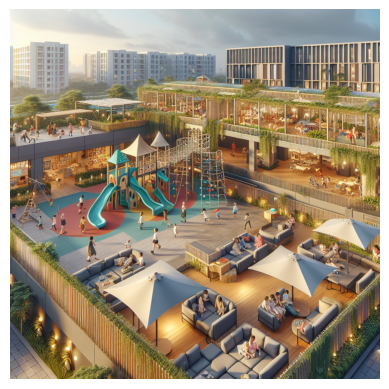

user_proxy (to assistant):

***** Response from calling function "ask_dalle" *****
[{'type': 'image_url', 'image_url': {'url': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x26DB9DE3B10>}}]
******************************************************

--------------------------------------------------------------------------------
assistant (to user_proxy):

***** Suggested function Call: ask_user *****
Arguments: 
{
  "message": "项目名称：深圳南山区城中村活动中心更新项目。地点：深圳市南山区城中村。项目类型：城市更新。占地面积：约1000平方米。项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求。设计范围包括建筑设计、景观设计、室内布局和环境友好等方面。请问您对这个项目有什么想法和建议？",
  "num": "2"
}
*********************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION ask_user...
architecture_UserProxy2 (to architecture_user2):

项目名称：深圳南山区城中村活动中心更新项目。地点：深圳市南山区城中村。项目类型：城市更新。占地面积：约1000平方米。项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求

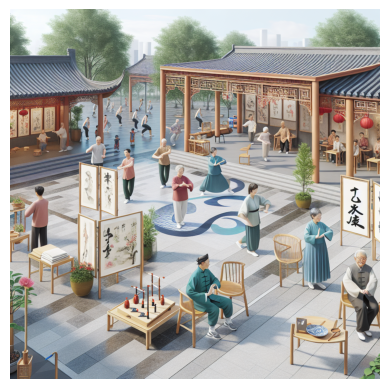

user_proxy (to assistant):

***** Response from calling function "ask_dalle" *****
[{'type': 'image_url', 'image_url': {'url': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x26DB8478090>}}]
******************************************************

--------------------------------------------------------------------------------
assistant (to user_proxy):

所有任务已完成。TERMINATE

--------------------------------------------------------------------------------


In [134]:
## For test
# sysmessage_bundle = []
# with open("G:\OneDrive\Thesis\PipelineProject\save_config_79272c5edc889e41eac664eacf5e9aa4.json", 'r', encoding='utf-8') as file:
#     data = json.load(file)
#     # Assuming 'agent_configs' is a list within the JSON structure
#     sysmessage_bundle.append(data['agent_configs'][4]["system_message"])
#     sysmessage_bundle.append(data['agent_configs'][5]["system_message"])

##    ------------------   ------------------   ------------------   ------------------   ------------------   ------------------   ------------------
 # 装载用户和Proxy
chatlist = []
archUserProxyList = []
archUserList = []
for i in range(len(sysmessage_bundle)): 
    # 输出描述词的user
    architecture_user = ConversableAgent(
        name=f"architecture_user{i+1}",
        llm_config={"config_list": gpt_config, "max_tokens": 1000
                    },
        system_message = sysmessage_bundle[i],
    )
    arch_UserProxy = autogen.UserProxyAgent(
        name=f"architecture_UserProxy{i+1}",
        max_consecutive_auto_reply=0,  # terminate without auto-reply
        human_input_mode="NEVER",
        code_execution_config={
            "use_docker": False
        }, 
    )
    archUserList.append(architecture_user)
    archUserProxyList.append(arch_UserProxy)

# 负责问Dalle的UserProxy
architecture_UserProxy = autogen.UserProxyAgent(
    name="architecture_UserProxy",
    max_consecutive_auto_reply=0,  # terminate without auto-reply
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 1,
        "use_docker": False
    }, 
)

# Main Assitant Agent
assistant = autogen.AssistantAgent(
    name="assistant",
    system_message = (
        f'你是一个建筑师的助手，你需要完成两个任务，1.总结建筑师给予的任务，向所有建筑使用者（architecture_user）提出咨询。'
        f'建筑使用者一共有{len(sysmessage_bundle)}个，你需要询问他们对场景的想象并邀请他们做出描述，2.将他们对空间的描述利用技能'
        '（ask_dalle）生成每一个人各自的定制化对应的空间场景图片，注意此处需要填入一系列的Prompt进行对场景描述，即一系列描述性短句，若对方的描述不到位，你可以根据对对方的理解加入提示词。'
        f'最终，总共生成的图片数量需要为{len(sysmessage_bundle)}张。在执行任务的过程中，你需要循序渐进进行，先询问第一位用户然后作图，'
        f'然后再询问第二位用户然后作图，途中不需要询问我的意见，等到所有任务完成后再来通知我。注意{termination_notice}'
    ),
    llm_config={
        "temperature": 0,
        "timeout": 600,
        "cache_seed": 42,
        "config_list": gpt_config,
        "functions": [
            {
                "name": "ask_dalle",
                "description": "此任务主要服务于使用者图片生成，通过调用dalle，根据提示词描述生成图片,",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "message": {
                            "type": "string",
                            "description": "这是建筑使用者对图片的描述，尽量保证这个描述有足够多的细节，并且是能够被生图模型清晰理解的提示词。同时你需要加入相关的提示词使得生成的图片必须要人视点，色彩风格要接近真实不要卡通风格，里面要存在人的活动。不要轴测图和平面图，要类似照片的风格。尽可能包含更多的人群。例如一张多汁牛排的照片，烤至五分熟并带有烧烤痕迹，摆放在木质盘子上。牛排周围散布着新鲜的迷迭香枝条和一缕酱汁。背景是一张质朴的木制餐桌。来自左上方的温暖、环境光投射出微妙的阴影，突出了牛排的质地。拍摄工具：单反相机，微距摄影，50mm镜头。",
                        },
                    },
                    "required": ["message"],
                },
            },
            {
                "name": "ask_user",
                "description": "此任务主要用于询问使用者（architecture_user）对于建筑项目的看法，参数包括两个，第一个为提问的问题，第二个为使用者的号码，一次执行只能询问一个使用者",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "message": {
                            "type": "string",
                            "description": "这是询问建筑项目中需要向使用者提出的问题，使用者是一个非建筑专业人士，需要用通俗易懂的语言翻译项目相关的内容交给使用者进行分析判断,注意内容中需要包含项目的选址，项目的功能和周边情况等基本信息",
                        },
                        "num": {
                            "type": "string",
                            "description": "这是使用者的编码，从1开始计数，即如果询问第一个使用者则用1作为输入参数，第二个则用2,以此类推",
                        },
                    },
                    "required": ["message","num"],
                },
            },
        ],
    },
)

def ask_dalle(message):
    architecture_UserProxy.initiate_chat(dalle, message=message)
    img = extract_img(dalle)
    plt.imshow(img)
    plt.axis("off")  # Turn off axis numbers
    plt.show()
    return architecture_UserProxy.last_message()["content"]

def ask_user(message, num):
    archUserProxyList[int(num)-1].initiate_chat(archUserList[int(num)-1], message=message)
    # return the last message received from the planner
    return archUserProxyList[int(num)-1].last_message(archUserList[int(num)-1])["content"] + "TERMINATE"

user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply = 10,
    is_termination_msg= lambda x: "content" in x and x["content"] is not None and x["content"].rstrip().endswith("TERMINATE"),
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "planning",
        "use_docker": False,
    }, 
    function_map={"ask_dalle": ask_dalle, 
                "ask_user" : ask_user},
)

# 发起第一次询问
chat_results = user_proxy.initiate_chat(
    assistant,
    message=task_description
)


### 设计咨询模块

此模块主要是提供一个简便的渠道实现建筑师和不同智能体之间的沟通。这个模块主要提供了两个功能，一是实现用户和特定代理的沟通交流，主要在第一部分的代码当中，二是实现用户和加强了建筑知识的建筑主智能体的交流，建筑主智能体能够和之前配置好的用户智能体和专家智能体进行讨论，同时检索数据库给出回复。目前如果需要

In [152]:
task = """我的这个设计方案你有什么看法？你们认为这个里面有什么可以改进的地方，每个人都说说，<img https://images.adsttc.com/media/images/6564/f939/0ca0/c36d/0a12/3616/medium_jpg/future-community-center-xikou-yad-studio_4.jpg?1701116228."""

#### 一、Agents群体讨论交流

In [155]:
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.agentchat.contrib.capabilities.vision_capability import VisionCapability

agent_list = []
with open(agent_saved_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
    for agent_config in data["agent_configs"]:
        agent = MultimodalConversableAgent(
            name=agent_config["name"],
            max_consecutive_auto_reply=5,  
            llm_config={"config_list": gpt4v_config, "temperature": 0.5, "max_tokens": 500},  # Adjust as necessary
            system_message = agent_config["system_message"],
        )
        agent_list.append(agent)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="理解图片中的内容并解决我的提问",
    human_input_mode="NEVER",  # Try between ALWAYS, NEVER, and TERMINATE
    max_consecutive_auto_reply=10,
    code_execution_config={
        "last_n_messages": 1,
        "use_docker": False,
        "work_dir": "groupchat",
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

inquire = f"我需要你们针对我的问题给出建议，并使用中文回答我后文提出的问题。注意不需要评价任务书和设计背景本身，不要给我和建议设计无关的建议如:邀请不同的AI助手，不需要总结其他人的建议，给出你自己的意见和评价。请关注我给你提出的具体问题。这个设计方案的具体设计背景与任务书描述为：{task_description}，我需要提出的问题为：{task}"

agent_list.append(user_proxy)
groupchat = autogen.GroupChat(agents=agent_list, messages=[], max_round=10)

vision_capability = VisionCapability(lmm_config={"config_list": gpt4v_config, "temperature": 0.5, "max_tokens": 300})
group_chat_manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_llm_config)
vision_capability.add_to_agent(group_chat_manager)

rst = user_proxy.initiate_chat(
    group_chat_manager,
    message = inquire,
)

User_proxy (to chat_manager):

我需要你们针对我的问题给出建议，并使用中文回答我后文提出的问题。注意不需要评价任务书和设计背景本身，不要给我和建议设计无关的建议如:邀请不同的AI助手，不需要总结其他人的建议，给出你自己的意见和评价。请关注我给你提出的具体问题。这个设计方案的具体设计背景与任务书描述为：项目名称：深圳南山区城中村活动中心更新项目
    地点：深圳市南山区城中村
    项目类型：城市更新
    占地面积：约1000平方米
    项目目标：将现有的城中村活动中心改建成一个现代化、多功能的社区中心，旨在提升社区居民的生活质量，促进社区文化的发展，以及满足社区居民多样化的活动需求。
    设计目标
    可持续发展：应用绿色建筑材料和技术，减少环境影响，确保项目的可持续性。
    灵活多用途空间：设计灵活的空间布局，以适应会议、展览、表演、休闲等多种用途。
    社区参与和归属感：鼓励社区居民参与设计和管理过程，增强社区归属感。
    文化融合：反映和融合城中村的历史文化元素，促进不同背景社区成员之间的文化交流。
    设计范围
    建筑设计：包括但不限于主体结构改造、外观设计、室内设计等。
    景观设计：包括户外休闲空间、绿化、以及适应各种社区活动的开放空间设计。
    室内布局：创造多功能空间，如图书馆、小剧场、会议室、工作坊、儿童游戏区等。
    环境友好：设计应考虑能源效率，使用可持续材料，以及雨水收集和利用系统。
    设计要求
    创新：鼓励采用创新的设计理念和技术，以提供独特的视觉和使用体验。
    灵活性：空间布局应灵活，能够适应不同活动和功能的需要。
    安全性：确保建筑物和周围环境的安全性，符合当地建筑规范和安全标准。
    文化敏感性：设计应敏感地反映和尊重当地社区的文化和历史。
    提交要求
    设计方案：包括概念设计方案、平面图、立面图、剖面图等。
    可行性报告：分析项目的经济、环境和社会可行性。
    材料和技术说明：详细说明选用的建筑材料、构造方法和环境技术。
    预算估算：提供项目的初步成本估算。
    时间表：项目的预计设计和施工时间表。
    评审和批准
    设计方案将由一个专家评审小组进行评审，评审标准包括创意、功能性、

#### 二、与单一智能体交流

In [136]:
index = 5
restart_chat = False


In [139]:
name = ""
sysMessage = ""

with open(agent_saved_path, 'r', encoding='utf-8') as file:
    data = json.load(file)
    name = data["agent_configs"][index]["name"]
    sysMessage = data["agent_configs"][index]["system_message"]

image_agent = MultimodalConversableAgent(
    name=name,
    max_consecutive_auto_reply=10,
    system_message= sysMessage,
    llm_config={"config_list": gpt4v_config, "temperature": 0.2, "max_tokens": 300},
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
    code_execution_config={
        "use_docker": False
    },  
)

#"""你喜欢我现在设计的这个方案么?
# .""",
# 你喜欢什么样的活动空间，我的这个空间你喜欢么，有什么建议可以给我？
#     <img https://images.adsttc.com/media/images/65e9/92b6/855b/f264/9e6f/7b9d/medium_jpg/six-bricolage-houses-in-nantou-arcity-office_1.jpg?1709806272>.
rs = user_proxy.initiate_chat(
    image_agent,
    clear_history= restart_chat,
    message="""第一第二个方案你更喜欢哪一个啊""",
)



User_proxy (to architecture_user1):

第一第二个方案你更喜欢哪一个啊

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
architecture_user1 (to User_proxy):

作为李阿姨，我会更关注哪个方案能更好地满足社区老年人的需求。如果第一个方案提供了更多的无障碍设施、休息区和适合老年人的运动设施，那么我可能会倾向于选择第一个方案。但是，我也会考虑两个方案对教育活动和传统文化庆祝活动的支持程度。我需要更多的信息来做出最终的决定。

--------------------------------------------------------------------------------
